In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor




In [3]:
from torch.utils.data import Dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
            

    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)
        transforms = Compose([ToTensor()])
        im = transforms(im)
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types }
        return sample

In [4]:
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)


/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/malign
number of data items:73
/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/repo/data/train/malign
number of data items:73


In [37]:
import cv2
import torch.nn as nn
import torch.nn.functional as F

z = 10 # groups
a = 15

G = np.random.randn(z, a)
W = np.random.randn(1, z)

   
def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 64, 5)
        
        self.fc1 = nn.Linear(14400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = self.pool(F.tanh(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x)

        
        y = torch.matmul(self.W_, g)
        
        return (torch.sigmoid(y), x)

model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)


criterion = torch.nn.L1Loss(reduction='sum')

criterion1 = torch.nn.MSELoss(reduction='sum')


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)
epoch = 0




In [6]:
model.load_state_dict(torch.load(f'../data/models/end_to_end_v1.pt'))

<All keys matched successfully>

In [41]:
for epoch in range(10000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)

        optimizer.zero_grad()

        (y_pred, attributes_pred) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), data["labels"][:, :15].to(device))
        
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

Epoch:  1 ; running-loss:  194.16037649004076
Epoch:  2 ; running-loss:  193.81799260239697
Epoch:  3 ; running-loss:  195.38228757434823
Epoch:  4 ; running-loss:  195.3240111968651
Epoch:  5 ; running-loss:  193.79637144264117
Epoch:  6 ; running-loss:  194.05558221607652
Epoch:  7 ; running-loss:  193.69956634018766
Epoch:  8 ; running-loss:  193.95492104604293
Epoch:  9 ; running-loss:  193.79077219460328
Epoch:  10 ; running-loss:  194.1265447731639
Epoch:  11 ; running-loss:  194.84095645261837
Epoch:  12 ; running-loss:  193.84655426855952
Epoch:  13 ; running-loss:  195.19607415550436
Epoch:  14 ; running-loss:  194.08189301392633
Epoch:  15 ; running-loss:  194.8105158112833
Epoch:  16 ; running-loss:  193.69456225479
Epoch:  17 ; running-loss:  193.8622209908167
Epoch:  18 ; running-loss:  193.93559050211675
Epoch:  19 ; running-loss:  192.75345922647597
Epoch:  20 ; running-loss:  193.7489915442337
Epoch:  21 ; running-loss:  194.8123832829857
Epoch:  22 ; running-loss:  194

Epoch:  176 ; running-loss:  189.93762243447873
Epoch:  177 ; running-loss:  190.0962118429515
Epoch:  178 ; running-loss:  189.13209087362577
Epoch:  179 ; running-loss:  189.87969977462325
Epoch:  180 ; running-loss:  189.59332443987648
Epoch:  181 ; running-loss:  190.66900107926025
Epoch:  182 ; running-loss:  191.33104096564944
Epoch:  183 ; running-loss:  190.45737227551547
Epoch:  184 ; running-loss:  189.67543594993464
Epoch:  185 ; running-loss:  190.08433107725673
Epoch:  186 ; running-loss:  191.21133933508844
Epoch:  187 ; running-loss:  191.6234659081056
Epoch:  188 ; running-loss:  189.8770674350272
Epoch:  189 ; running-loss:  189.04072714553843
Epoch:  190 ; running-loss:  189.49806291089612
Epoch:  191 ; running-loss:  191.67145190387015
Epoch:  192 ; running-loss:  189.30796931111428
Epoch:  193 ; running-loss:  188.20707978944975
Epoch:  194 ; running-loss:  187.95585771051066
Epoch:  195 ; running-loss:  190.1528539282766
Epoch:  196 ; running-loss:  187.75694998614

Epoch:  348 ; running-loss:  182.6702604754957
Epoch:  349 ; running-loss:  185.42053003085337
Epoch:  350 ; running-loss:  182.06014863437716
Epoch:  351 ; running-loss:  184.841809143799
Epoch:  352 ; running-loss:  181.62391604283403
Epoch:  353 ; running-loss:  182.71685140886515
Epoch:  354 ; running-loss:  181.89006495039072
Epoch:  355 ; running-loss:  180.31794824541845
Epoch:  356 ; running-loss:  181.17116376956002
Epoch:  357 ; running-loss:  181.5579547200391
Epoch:  358 ; running-loss:  182.8768951923692
Epoch:  359 ; running-loss:  181.45939729283765
Epoch:  360 ; running-loss:  183.10922714080104
Epoch:  361 ; running-loss:  181.4834470508429
Epoch:  362 ; running-loss:  179.62652724528994
Epoch:  363 ; running-loss:  179.72971233652623
Epoch:  364 ; running-loss:  181.60644764058353
Epoch:  365 ; running-loss:  181.86167616198642
Epoch:  366 ; running-loss:  184.8158140251912
Epoch:  367 ; running-loss:  182.86958717736826
Epoch:  368 ; running-loss:  180.97071684919348

Epoch:  520 ; running-loss:  173.1084818529915
Epoch:  521 ; running-loss:  170.9432046728598
Epoch:  522 ; running-loss:  172.6615015297946
Epoch:  523 ; running-loss:  173.98170575531125
Epoch:  524 ; running-loss:  170.83309341768054
Epoch:  525 ; running-loss:  172.5783321619403
Epoch:  526 ; running-loss:  171.90379229072025
Epoch:  527 ; running-loss:  170.2743483098045
Epoch:  528 ; running-loss:  173.82257929126746
Epoch:  529 ; running-loss:  171.51974233940092
Epoch:  530 ; running-loss:  171.24885303798314
Epoch:  531 ; running-loss:  174.24429454910813
Epoch:  532 ; running-loss:  172.238635948918
Epoch:  533 ; running-loss:  171.66078407114964
Epoch:  534 ; running-loss:  171.42792094867326
Epoch:  535 ; running-loss:  173.63434581256888
Epoch:  536 ; running-loss:  173.5289266866659
Epoch:  537 ; running-loss:  172.39826130270575
Epoch:  538 ; running-loss:  172.07506154602322
Epoch:  539 ; running-loss:  170.96189717196725
Epoch:  540 ; running-loss:  170.29480456616295


Epoch:  692 ; running-loss:  157.56789360299817
Epoch:  693 ; running-loss:  158.29823509089255
Epoch:  694 ; running-loss:  161.0469575344645
Epoch:  695 ; running-loss:  159.50759358523004
Epoch:  696 ; running-loss:  160.41591681045372
Epoch:  697 ; running-loss:  158.4931757205705
Epoch:  698 ; running-loss:  164.20947472713314
Epoch:  699 ; running-loss:  160.945314887
Epoch:  700 ; running-loss:  158.02712855487357
Epoch:  701 ; running-loss:  154.41723861257546
Epoch:  702 ; running-loss:  160.08191063337935
Epoch:  703 ; running-loss:  157.0161600401346
Epoch:  704 ; running-loss:  158.59330485266713
Epoch:  705 ; running-loss:  156.38656821561062
Epoch:  706 ; running-loss:  159.52335576126995
Epoch:  707 ; running-loss:  156.97385048889674
Epoch:  708 ; running-loss:  158.93161367593768
Epoch:  709 ; running-loss:  158.87023738155386
Epoch:  710 ; running-loss:  159.70120320148106
Epoch:  711 ; running-loss:  158.3872007127744
Epoch:  712 ; running-loss:  161.69481542359887
E

Epoch:  864 ; running-loss:  146.6694350299
Epoch:  865 ; running-loss:  145.92628221010943
Epoch:  866 ; running-loss:  148.30038221501755
Epoch:  867 ; running-loss:  141.85252253637083
Epoch:  868 ; running-loss:  146.46307985341602
Epoch:  869 ; running-loss:  145.51713515173847
Epoch:  870 ; running-loss:  147.68969723279994
Epoch:  871 ; running-loss:  144.36630249363603
Epoch:  872 ; running-loss:  143.26507967460947
Epoch:  873 ; running-loss:  141.7541139022489
Epoch:  874 ; running-loss:  146.08085273744447
Epoch:  875 ; running-loss:  144.4320363665593
Epoch:  876 ; running-loss:  143.7945477200956
Epoch:  877 ; running-loss:  141.0836091629392
Epoch:  878 ; running-loss:  144.250771458567
Epoch:  879 ; running-loss:  144.09092305915067
Epoch:  880 ; running-loss:  141.91285033295193
Epoch:  881 ; running-loss:  143.2567269952564
Epoch:  882 ; running-loss:  141.1377220997229
Epoch:  883 ; running-loss:  145.47748565600588
Epoch:  884 ; running-loss:  144.7567588379723
Epoch

Epoch:  1036 ; running-loss:  126.3155470974554
Epoch:  1037 ; running-loss:  128.6850854864232
Epoch:  1038 ; running-loss:  126.22737532571975
Epoch:  1039 ; running-loss:  124.51347519756554
Epoch:  1040 ; running-loss:  128.10472415979933
Epoch:  1041 ; running-loss:  130.2077119347879
Epoch:  1042 ; running-loss:  124.3877902723469
Epoch:  1043 ; running-loss:  120.8218022278078
Epoch:  1044 ; running-loss:  120.86238830056001
Epoch:  1045 ; running-loss:  124.98142781861925
Epoch:  1046 ; running-loss:  125.62673768177146
Epoch:  1047 ; running-loss:  122.51090565994299
Epoch:  1048 ; running-loss:  125.36152499042227
Epoch:  1049 ; running-loss:  124.64380008441779
Epoch:  1050 ; running-loss:  125.05631261549684
Epoch:  1051 ; running-loss:  122.11064991622256
Epoch:  1052 ; running-loss:  119.36793538823746
Epoch:  1053 ; running-loss:  129.31703318792287
Epoch:  1054 ; running-loss:  120.79070314963629
Epoch:  1055 ; running-loss:  124.8112744048764
Epoch:  1056 ; running-los

Epoch:  1204 ; running-loss:  106.74593479224488
Epoch:  1205 ; running-loss:  107.87171322819114
Epoch:  1206 ; running-loss:  113.61473563678214
Epoch:  1207 ; running-loss:  105.70667030235626
Epoch:  1208 ; running-loss:  102.30430955775982
Epoch:  1209 ; running-loss:  109.30237414444522
Epoch:  1210 ; running-loss:  103.97465173288337
Epoch:  1211 ; running-loss:  108.12493373558435
Epoch:  1212 ; running-loss:  109.86356137143568
Epoch:  1213 ; running-loss:  110.4082747120614
Epoch:  1214 ; running-loss:  103.44327567702311
Epoch:  1215 ; running-loss:  100.53062039270316
Epoch:  1216 ; running-loss:  106.17616227216507
Epoch:  1217 ; running-loss:  104.16748814577514
Epoch:  1218 ; running-loss:  101.64883250480383
Epoch:  1219 ; running-loss:  105.3288743811411
Epoch:  1220 ; running-loss:  110.39245770512726
Epoch:  1221 ; running-loss:  110.64525986774538
Epoch:  1222 ; running-loss:  107.29922510310422
Epoch:  1223 ; running-loss:  106.08542400493776
Epoch:  1224 ; running

Epoch:  1374 ; running-loss:  95.34157681129274
Epoch:  1375 ; running-loss:  91.36980621422745
Epoch:  1376 ; running-loss:  94.43299833484426
Epoch:  1377 ; running-loss:  91.49862305860411
Epoch:  1378 ; running-loss:  94.94004523317454
Epoch:  1379 ; running-loss:  91.23738540723008
Epoch:  1380 ; running-loss:  91.54107967067687
Epoch:  1381 ; running-loss:  89.76564431877966
Epoch:  1382 ; running-loss:  85.70597851271714
Epoch:  1383 ; running-loss:  89.42033534971203
Epoch:  1384 ; running-loss:  92.36182247507169
Epoch:  1385 ; running-loss:  91.53548435059372
Epoch:  1386 ; running-loss:  87.38215332853163
Epoch:  1387 ; running-loss:  90.05401736500404
Epoch:  1388 ; running-loss:  88.69299144671035
Epoch:  1389 ; running-loss:  91.22537170892447
Epoch:  1390 ; running-loss:  90.80799760241247
Epoch:  1391 ; running-loss:  90.96131503145445
Epoch:  1392 ; running-loss:  91.39941010751501
Epoch:  1393 ; running-loss:  93.10244442089756
Epoch:  1394 ; running-loss:  88.5739171

Epoch:  1546 ; running-loss:  76.86417620257515
Epoch:  1547 ; running-loss:  74.0358489675597
Epoch:  1548 ; running-loss:  75.63239080574462
Epoch:  1549 ; running-loss:  76.169812903555
Epoch:  1550 ; running-loss:  80.52900432277829
Epoch:  1551 ; running-loss:  76.93505163888726
Epoch:  1552 ; running-loss:  75.7221290264078
Epoch:  1553 ; running-loss:  72.64469458774192
Epoch:  1554 ; running-loss:  73.08641979948693
Epoch:  1555 ; running-loss:  79.89261182823262
Epoch:  1556 ; running-loss:  76.33242824093557
Epoch:  1557 ; running-loss:  78.74888430880564
Epoch:  1558 ; running-loss:  81.43519165570743
Epoch:  1559 ; running-loss:  80.13035026504474
Epoch:  1560 ; running-loss:  74.74105683400211
Epoch:  1561 ; running-loss:  75.83535392187487
Epoch:  1562 ; running-loss:  75.89584110990438
Epoch:  1563 ; running-loss:  79.9494830137004
Epoch:  1564 ; running-loss:  76.3137353391739
Epoch:  1565 ; running-loss:  75.35432738219045
Epoch:  1566 ; running-loss:  77.8918316704842

Epoch:  1718 ; running-loss:  66.36656581083417
Epoch:  1719 ; running-loss:  68.19169483780638
Epoch:  1720 ; running-loss:  66.48208313635506
Epoch:  1721 ; running-loss:  67.37307325829057
Epoch:  1722 ; running-loss:  61.98476122659182
Epoch:  1723 ; running-loss:  67.66241911964963
Epoch:  1724 ; running-loss:  64.56001694690103
Epoch:  1725 ; running-loss:  68.98536951612796
Epoch:  1726 ; running-loss:  67.20375883582864
Epoch:  1727 ; running-loss:  66.52193592088788
Epoch:  1728 ; running-loss:  65.50868235145873
Epoch:  1729 ; running-loss:  64.98153489921145
Epoch:  1730 ; running-loss:  67.47581784512286
Epoch:  1731 ; running-loss:  64.86706479940885
Epoch:  1732 ; running-loss:  65.62897508739327
Epoch:  1733 ; running-loss:  63.78414103976265
Epoch:  1734 ; running-loss:  68.30202255457088
Epoch:  1735 ; running-loss:  65.41681031384661
Epoch:  1736 ; running-loss:  66.80923019613782
Epoch:  1737 ; running-loss:  63.04475143048805
Epoch:  1738 ; running-loss:  66.0222993

Epoch:  1889 ; running-loss:  55.66380760385102
Epoch:  1890 ; running-loss:  60.34394808399839
Epoch:  1891 ; running-loss:  55.83751131256021
Epoch:  1892 ; running-loss:  53.333738956505755
Epoch:  1893 ; running-loss:  54.71959555812263
Epoch:  1894 ; running-loss:  55.599768523989624
Epoch:  1895 ; running-loss:  60.00214795326074
Epoch:  1896 ; running-loss:  56.817592879059276
Epoch:  1897 ; running-loss:  58.04233862351178
Epoch:  1898 ; running-loss:  56.67178220766766
Epoch:  1899 ; running-loss:  58.85947285272099
Epoch:  1900 ; running-loss:  56.929255916808394
Epoch:  1901 ; running-loss:  58.7571423321101
Epoch:  1902 ; running-loss:  57.51533688337156
Epoch:  1903 ; running-loss:  57.0590399394883
Epoch:  1904 ; running-loss:  57.95599215397077
Epoch:  1905 ; running-loss:  57.72790025385437
Epoch:  1906 ; running-loss:  57.05766982820967
Epoch:  1907 ; running-loss:  55.45375407902985
Epoch:  1908 ; running-loss:  56.14826015512621
Epoch:  1909 ; running-loss:  55.80020

Epoch:  2059 ; running-loss:  55.07327380701734
Epoch:  2060 ; running-loss:  50.219458979059645
Epoch:  2061 ; running-loss:  49.12327084022648
Epoch:  2062 ; running-loss:  48.64706960690164
Epoch:  2063 ; running-loss:  48.730130820618164
Epoch:  2064 ; running-loss:  49.67684339927027
Epoch:  2065 ; running-loss:  49.302410990208756
Epoch:  2066 ; running-loss:  50.67687373233773
Epoch:  2067 ; running-loss:  50.817819740559784
Epoch:  2068 ; running-loss:  50.987950595112004
Epoch:  2069 ; running-loss:  51.8662980227444
Epoch:  2070 ; running-loss:  49.300043024805305
Epoch:  2071 ; running-loss:  48.799339312376745
Epoch:  2072 ; running-loss:  47.23671336688165
Epoch:  2073 ; running-loss:  51.44238117738282
Epoch:  2074 ; running-loss:  51.56718042817841
Epoch:  2075 ; running-loss:  50.50618532369079
Epoch:  2076 ; running-loss:  51.70378361275444
Epoch:  2077 ; running-loss:  47.37479612247497
Epoch:  2078 ; running-loss:  52.13937927414776
Epoch:  2079 ; running-loss:  49.8

Epoch:  2230 ; running-loss:  45.04837465487898
Epoch:  2231 ; running-loss:  46.39455169483134
Epoch:  2232 ; running-loss:  44.44567991005376
Epoch:  2233 ; running-loss:  43.61382945531484
Epoch:  2234 ; running-loss:  44.20452094662263
Epoch:  2235 ; running-loss:  46.66118255056523
Epoch:  2236 ; running-loss:  44.022638402749486
Epoch:  2237 ; running-loss:  45.35675715411296
Epoch:  2238 ; running-loss:  43.24319229413496
Epoch:  2239 ; running-loss:  44.54420235799885
Epoch:  2240 ; running-loss:  44.1475568532189
Epoch:  2241 ; running-loss:  46.1281225897593
Epoch:  2242 ; running-loss:  43.3929640155284
Epoch:  2243 ; running-loss:  43.71763441735715
Epoch:  2244 ; running-loss:  44.26335597881461
Epoch:  2245 ; running-loss:  46.710870048294126
Epoch:  2246 ; running-loss:  45.24465513545351
Epoch:  2247 ; running-loss:  43.92713406393232
Epoch:  2248 ; running-loss:  44.61132807386313
Epoch:  2249 ; running-loss:  46.00722082223628
Epoch:  2250 ; running-loss:  44.76048669

Epoch:  2401 ; running-loss:  40.30595202535512
Epoch:  2402 ; running-loss:  40.37386480001309
Epoch:  2403 ; running-loss:  41.8549373750944
Epoch:  2404 ; running-loss:  39.93261173274785
Epoch:  2405 ; running-loss:  41.98019105903687
Epoch:  2406 ; running-loss:  40.73381198044335
Epoch:  2407 ; running-loss:  38.73442945314308
Epoch:  2408 ; running-loss:  39.88032929077786
Epoch:  2409 ; running-loss:  40.16859880059034
Epoch:  2410 ; running-loss:  39.61867662997191
Epoch:  2411 ; running-loss:  39.6357025190055
Epoch:  2412 ; running-loss:  40.07703631206829
Epoch:  2413 ; running-loss:  39.178855310930125
Epoch:  2414 ; running-loss:  41.0283323933972
Epoch:  2415 ; running-loss:  40.31556072956069
Epoch:  2416 ; running-loss:  40.779935351914666
Epoch:  2417 ; running-loss:  41.627436738828536
Epoch:  2418 ; running-loss:  39.71784404340166
Epoch:  2419 ; running-loss:  40.79418620420935
Epoch:  2420 ; running-loss:  40.67715305947465
Epoch:  2421 ; running-loss:  42.0872231

Epoch:  2571 ; running-loss:  37.453595922807125
Epoch:  2572 ; running-loss:  38.35612559442822
Epoch:  2573 ; running-loss:  37.19927062067794
Epoch:  2574 ; running-loss:  37.0765315363783
Epoch:  2575 ; running-loss:  36.0814978427922
Epoch:  2576 ; running-loss:  37.38822006848485
Epoch:  2577 ; running-loss:  38.68346829679857
Epoch:  2578 ; running-loss:  36.70358966273909
Epoch:  2579 ; running-loss:  37.719318284999815
Epoch:  2580 ; running-loss:  38.9494043580786
Epoch:  2581 ; running-loss:  37.70079553641011
Epoch:  2582 ; running-loss:  37.10282201176543
Epoch:  2583 ; running-loss:  37.29006788001065
Epoch:  2584 ; running-loss:  37.53230903082528
Epoch:  2585 ; running-loss:  38.69298966417474
Epoch:  2586 ; running-loss:  37.040808795772975
Epoch:  2587 ; running-loss:  36.61523872554058
Epoch:  2588 ; running-loss:  37.52683765947242
Epoch:  2589 ; running-loss:  38.930922423582054
Epoch:  2590 ; running-loss:  37.17162629850255
Epoch:  2591 ; running-loss:  36.873705

Epoch:  2741 ; running-loss:  35.33218439818986
Epoch:  2742 ; running-loss:  34.833735228858615
Epoch:  2743 ; running-loss:  35.103971946321636
Epoch:  2744 ; running-loss:  35.313131493641734
Epoch:  2745 ; running-loss:  35.593657220921365
Epoch:  2746 ; running-loss:  36.56551614385333
Epoch:  2747 ; running-loss:  35.010876645078405
Epoch:  2748 ; running-loss:  35.11814644401854
Epoch:  2749 ; running-loss:  35.86773740086823
Epoch:  2750 ; running-loss:  34.8649534553432
Epoch:  2751 ; running-loss:  35.42911291280771
Epoch:  2752 ; running-loss:  35.801550357498925
Epoch:  2753 ; running-loss:  35.3890937199572
Epoch:  2754 ; running-loss:  35.370941646293105
Epoch:  2755 ; running-loss:  35.1315237545635
Epoch:  2756 ; running-loss:  35.646149903454436
Epoch:  2757 ; running-loss:  35.546468385409995
Epoch:  2758 ; running-loss:  35.6065755080285
Epoch:  2759 ; running-loss:  34.93289645468733
Epoch:  2760 ; running-loss:  34.648526956989194
Epoch:  2761 ; running-loss:  33.9

Epoch:  2911 ; running-loss:  33.01306412793499
Epoch:  2912 ; running-loss:  34.07396943559915
Epoch:  2913 ; running-loss:  33.52131043209019
Epoch:  2914 ; running-loss:  33.11296164073255
Epoch:  2915 ; running-loss:  33.82358698727293
Epoch:  2916 ; running-loss:  33.50886835408555
Epoch:  2917 ; running-loss:  32.78055325685246
Epoch:  2918 ; running-loss:  33.11355815957022
Epoch:  2919 ; running-loss:  33.64465561675075
Epoch:  2920 ; running-loss:  34.05367294350472
Epoch:  2921 ; running-loss:  33.18601509573875
Epoch:  2922 ; running-loss:  33.54087730209435
Epoch:  2923 ; running-loss:  33.69265924702497
Epoch:  2924 ; running-loss:  33.16874658469375
Epoch:  2925 ; running-loss:  33.48241246397848
Epoch:  2926 ; running-loss:  32.5444727926695
Epoch:  2927 ; running-loss:  33.43672568551605
Epoch:  2928 ; running-loss:  33.16027663583662
Epoch:  2929 ; running-loss:  32.74428466570185
Epoch:  2930 ; running-loss:  32.61620517554441
Epoch:  2931 ; running-loss:  33.12109768

Epoch:  3082 ; running-loss:  31.804290016492594
Epoch:  3083 ; running-loss:  32.041663060163515
Epoch:  3084 ; running-loss:  32.47715107281755
Epoch:  3085 ; running-loss:  31.612376191732572
Epoch:  3086 ; running-loss:  32.10651002120625
Epoch:  3087 ; running-loss:  32.33664311058754
Epoch:  3088 ; running-loss:  31.57071995228521
Epoch:  3089 ; running-loss:  31.511441770023954
Epoch:  3090 ; running-loss:  32.17505062000605
Epoch:  3091 ; running-loss:  31.843680158306537
Epoch:  3092 ; running-loss:  31.647228039097612
Epoch:  3093 ; running-loss:  31.561531281857143
Epoch:  3094 ; running-loss:  31.539253746242977
Epoch:  3095 ; running-loss:  31.719961695107877
Epoch:  3096 ; running-loss:  32.24611180868767
Epoch:  3097 ; running-loss:  32.03184988741333
Epoch:  3098 ; running-loss:  31.587809564253803
Epoch:  3099 ; running-loss:  32.1738027015075
Epoch:  3100 ; running-loss:  32.18482189190104
Epoch:  3101 ; running-loss:  32.178818891005136
Epoch:  3102 ; running-loss:  

Epoch:  3251 ; running-loss:  30.570289416966606
Epoch:  3252 ; running-loss:  30.810919380970734
Epoch:  3253 ; running-loss:  30.560833352869114
Epoch:  3254 ; running-loss:  30.575739641141276
Epoch:  3255 ; running-loss:  30.27711952341916
Epoch:  3256 ; running-loss:  30.640798047670437
Epoch:  3257 ; running-loss:  30.802403028536187
Epoch:  3258 ; running-loss:  30.564097026439224
Epoch:  3259 ; running-loss:  30.42035291934081
Epoch:  3260 ; running-loss:  30.74623654857325
Epoch:  3261 ; running-loss:  30.630326233504967
Epoch:  3262 ; running-loss:  30.477719116369578
Epoch:  3263 ; running-loss:  30.751346087287345
Epoch:  3264 ; running-loss:  30.91880306792657
Epoch:  3265 ; running-loss:  30.33764994808283
Epoch:  3266 ; running-loss:  30.79937257391612
Epoch:  3267 ; running-loss:  30.968621932501193
Epoch:  3268 ; running-loss:  30.045226027894003
Epoch:  3269 ; running-loss:  29.98606862057111
Epoch:  3270 ; running-loss:  30.11754850671514
Epoch:  3271 ; running-loss:

Epoch:  3420 ; running-loss:  29.658150164955718
Epoch:  3421 ; running-loss:  29.10105480597202
Epoch:  3422 ; running-loss:  29.311466465543443
Epoch:  3423 ; running-loss:  29.159684562755576
Epoch:  3424 ; running-loss:  29.45460724999147
Epoch:  3425 ; running-loss:  29.615496654018898
Epoch:  3426 ; running-loss:  29.66144425072405
Epoch:  3427 ; running-loss:  29.46287167857812
Epoch:  3428 ; running-loss:  29.435018740866997
Epoch:  3429 ; running-loss:  29.42911156172361
Epoch:  3430 ; running-loss:  29.01422294856087
Epoch:  3431 ; running-loss:  29.14880772747565
Epoch:  3432 ; running-loss:  28.957246497075225
Epoch:  3433 ; running-loss:  29.563469461871403
Epoch:  3434 ; running-loss:  29.62767822642479
Epoch:  3435 ; running-loss:  28.903769535106225
Epoch:  3436 ; running-loss:  29.722495184551306
Epoch:  3437 ; running-loss:  29.55802590784196
Epoch:  3438 ; running-loss:  29.020772326398895
Epoch:  3439 ; running-loss:  28.836581313557463
Epoch:  3440 ; running-loss: 

Epoch:  3589 ; running-loss:  28.533421992650744
Epoch:  3590 ; running-loss:  28.550219973117855
Epoch:  3591 ; running-loss:  27.848384857416928
Epoch:  3592 ; running-loss:  27.82464647229812
Epoch:  3593 ; running-loss:  28.497025340665584
Epoch:  3594 ; running-loss:  28.191385259430636
Epoch:  3595 ; running-loss:  28.443609308487773
Epoch:  3596 ; running-loss:  28.14735808732468
Epoch:  3597 ; running-loss:  28.491529072996386
Epoch:  3598 ; running-loss:  28.046319052833176
Epoch:  3599 ; running-loss:  27.898739396067498
Epoch:  3600 ; running-loss:  28.240536183184425
Epoch:  3601 ; running-loss:  28.436928284364264
Epoch:  3602 ; running-loss:  28.311417514426715
Epoch:  3603 ; running-loss:  27.99068628658256
Epoch:  3604 ; running-loss:  28.388998729396455
Epoch:  3605 ; running-loss:  27.809158235857655
Epoch:  3606 ; running-loss:  28.378896037445344
Epoch:  3607 ; running-loss:  27.945293644975244
Epoch:  3608 ; running-loss:  27.88968432287747
Epoch:  3609 ; running-l

Epoch:  3758 ; running-loss:  26.904290549373954
Epoch:  3759 ; running-loss:  26.78108674335282
Epoch:  3760 ; running-loss:  27.352038331928327
Epoch:  3761 ; running-loss:  26.74454744166552
Epoch:  3762 ; running-loss:  27.189855072804328
Epoch:  3763 ; running-loss:  26.78738206494055
Epoch:  3764 ; running-loss:  27.053613478829494
Epoch:  3765 ; running-loss:  27.04923666878862
Epoch:  3766 ; running-loss:  27.24941715702657
Epoch:  3767 ; running-loss:  27.08482567310613
Epoch:  3768 ; running-loss:  26.638391358760835
Epoch:  3769 ; running-loss:  27.21505546218089
Epoch:  3770 ; running-loss:  26.816717008603266
Epoch:  3771 ; running-loss:  27.139714996286944
Epoch:  3772 ; running-loss:  26.83096515441452
Epoch:  3773 ; running-loss:  26.71302503231462
Epoch:  3774 ; running-loss:  26.602130555329836
Epoch:  3775 ; running-loss:  27.266704632215987
Epoch:  3776 ; running-loss:  26.944464449385595
Epoch:  3777 ; running-loss:  26.85021829522603
Epoch:  3778 ; running-loss:  

Epoch:  3927 ; running-loss:  25.898234789833282
Epoch:  3928 ; running-loss:  26.26849177030269
Epoch:  3929 ; running-loss:  26.045619943936394
Epoch:  3930 ; running-loss:  26.204054597054874
Epoch:  3931 ; running-loss:  26.27703474283921
Epoch:  3932 ; running-loss:  25.67793431788381
Epoch:  3933 ; running-loss:  26.121603009112754
Epoch:  3934 ; running-loss:  26.24097501354981
Epoch:  3935 ; running-loss:  26.24716608114089
Epoch:  3936 ; running-loss:  25.86558897282089
Epoch:  3937 ; running-loss:  25.64918840731427
Epoch:  3938 ; running-loss:  26.169164762002644
Epoch:  3939 ; running-loss:  26.155775195195325
Epoch:  3940 ; running-loss:  25.833227235481765
Epoch:  3941 ; running-loss:  25.61213274995944
Epoch:  3942 ; running-loss:  25.64539054839044
Epoch:  3943 ; running-loss:  25.64479611680978
Epoch:  3944 ; running-loss:  25.83866183256492
Epoch:  3945 ; running-loss:  26.136415954581217
Epoch:  3946 ; running-loss:  25.720097297245943
Epoch:  3947 ; running-loss:  2

Epoch:  4096 ; running-loss:  25.29319293515022
Epoch:  4097 ; running-loss:  24.997701696882693
Epoch:  4098 ; running-loss:  24.803799965188144
Epoch:  4099 ; running-loss:  24.904792656566563
Epoch:  4100 ; running-loss:  24.7730869254465
Epoch:  4101 ; running-loss:  25.209856935733647
Epoch:  4102 ; running-loss:  24.898343552002174
Epoch:  4103 ; running-loss:  24.926266649503948
Epoch:  4104 ; running-loss:  25.025477647374643
Epoch:  4105 ; running-loss:  24.859685705432263
Epoch:  4106 ; running-loss:  25.19190275099824
Epoch:  4107 ; running-loss:  24.879902293905495
Epoch:  4108 ; running-loss:  24.648817539478095
Epoch:  4109 ; running-loss:  24.77995250990708
Epoch:  4110 ; running-loss:  25.15813598541732
Epoch:  4111 ; running-loss:  25.21105580073898
Epoch:  4112 ; running-loss:  25.168592489901872
Epoch:  4113 ; running-loss:  25.160506655615766
Epoch:  4114 ; running-loss:  24.651231812751327
Epoch:  4115 ; running-loss:  24.98715273118303
Epoch:  4116 ; running-loss:

Epoch:  4265 ; running-loss:  24.18578482029843
Epoch:  4266 ; running-loss:  23.918298525404246
Epoch:  4267 ; running-loss:  23.99557041441116
Epoch:  4268 ; running-loss:  23.90784930464854
Epoch:  4269 ; running-loss:  24.407657454705955
Epoch:  4270 ; running-loss:  24.08700914476822
Epoch:  4271 ; running-loss:  24.135045719719486
Epoch:  4272 ; running-loss:  24.14561166920423
Epoch:  4273 ; running-loss:  23.97113852197054
Epoch:  4274 ; running-loss:  23.841511799093364
Epoch:  4275 ; running-loss:  24.029447964394237
Epoch:  4276 ; running-loss:  24.46379839340361
Epoch:  4277 ; running-loss:  24.201199726557995
Epoch:  4278 ; running-loss:  23.98928461183854
Epoch:  4279 ; running-loss:  24.318322329224245
Epoch:  4280 ; running-loss:  24.378543306623936
Epoch:  4281 ; running-loss:  24.244999671253893
Epoch:  4282 ; running-loss:  24.028734488763252
Epoch:  4283 ; running-loss:  24.27244036965077
Epoch:  4284 ; running-loss:  24.214204149726203
Epoch:  4285 ; running-loss: 

Epoch:  4434 ; running-loss:  23.06854641546245
Epoch:  4435 ; running-loss:  23.349229085639728
Epoch:  4436 ; running-loss:  23.144156334668942
Epoch:  4437 ; running-loss:  23.383606387516366
Epoch:  4438 ; running-loss:  23.3134359940321
Epoch:  4439 ; running-loss:  23.03023561130757
Epoch:  4440 ; running-loss:  23.245755303995114
Epoch:  4441 ; running-loss:  23.445387073751192
Epoch:  4442 ; running-loss:  23.506270843896484
Epoch:  4443 ; running-loss:  23.001260643939812
Epoch:  4444 ; running-loss:  23.350226906769443
Epoch:  4445 ; running-loss:  22.99932468624162
Epoch:  4446 ; running-loss:  22.98506651873324
Epoch:  4447 ; running-loss:  23.186417266429267
Epoch:  4448 ; running-loss:  23.494112455613745
Epoch:  4449 ; running-loss:  23.64978740188603
Epoch:  4450 ; running-loss:  23.282339584946158
Epoch:  4451 ; running-loss:  23.385964118285628
Epoch:  4452 ; running-loss:  23.246448811173433
Epoch:  4453 ; running-loss:  23.278824739039035
Epoch:  4454 ; running-loss

Epoch:  4603 ; running-loss:  22.60528590968728
Epoch:  4604 ; running-loss:  22.469277134640368
Epoch:  4605 ; running-loss:  22.27168535587283
Epoch:  4606 ; running-loss:  22.577637502755522
Epoch:  4607 ; running-loss:  22.288304738488602
Epoch:  4608 ; running-loss:  22.408421277742605
Epoch:  4609 ; running-loss:  22.50295016340681
Epoch:  4610 ; running-loss:  22.474463072977372
Epoch:  4611 ; running-loss:  22.49774333083118
Epoch:  4612 ; running-loss:  22.394783262746003
Epoch:  4613 ; running-loss:  22.40445860109581
Epoch:  4614 ; running-loss:  22.553835247365736
Epoch:  4615 ; running-loss:  22.517890444663298
Epoch:  4616 ; running-loss:  23.103946353180596
Epoch:  4617 ; running-loss:  22.57227020732353
Epoch:  4618 ; running-loss:  22.41400537601897
Epoch:  4619 ; running-loss:  22.237970132415278
Epoch:  4620 ; running-loss:  22.189896132151958
Epoch:  4621 ; running-loss:  22.326656580105745
Epoch:  4622 ; running-loss:  22.540205168806562
Epoch:  4623 ; running-loss

Epoch:  4772 ; running-loss:  21.72766984581209
Epoch:  4773 ; running-loss:  21.42532827167458
Epoch:  4774 ; running-loss:  21.749974769692695
Epoch:  4775 ; running-loss:  21.66352611095667
Epoch:  4776 ; running-loss:  21.909132314774446
Epoch:  4777 ; running-loss:  21.60770758280362
Epoch:  4778 ; running-loss:  21.95960764756343
Epoch:  4779 ; running-loss:  21.868207050467735
Epoch:  4780 ; running-loss:  21.566228426950026
Epoch:  4781 ; running-loss:  21.939910500784926
Epoch:  4782 ; running-loss:  21.59236720087478
Epoch:  4783 ; running-loss:  21.327724034320827
Epoch:  4784 ; running-loss:  21.632199547537095
Epoch:  4785 ; running-loss:  21.56733902440309
Epoch:  4786 ; running-loss:  21.752927867507708
Epoch:  4787 ; running-loss:  21.439546237875
Epoch:  4788 ; running-loss:  21.528444708968788
Epoch:  4789 ; running-loss:  21.81765619651105
Epoch:  4790 ; running-loss:  21.362443118713813
Epoch:  4791 ; running-loss:  21.525633940120706
Epoch:  4792 ; running-loss:  2

Epoch:  4941 ; running-loss:  21.02980719665855
Epoch:  4942 ; running-loss:  21.029343629264083
Epoch:  4943 ; running-loss:  20.663885700534898
Epoch:  4944 ; running-loss:  20.923225845098873
Epoch:  4945 ; running-loss:  20.927840733929823
Epoch:  4946 ; running-loss:  20.9144940182335
Epoch:  4947 ; running-loss:  21.107405664672715
Epoch:  4948 ; running-loss:  21.107064228239572
Epoch:  4949 ; running-loss:  20.98305684015981
Epoch:  4950 ; running-loss:  20.72869257304231
Epoch:  4951 ; running-loss:  20.973668725282337
Epoch:  4952 ; running-loss:  21.208509929502288
Epoch:  4953 ; running-loss:  21.18772176715265
Epoch:  4954 ; running-loss:  20.90964219348378
Epoch:  4955 ; running-loss:  21.152386886183095
Epoch:  4956 ; running-loss:  21.102307693480636
Epoch:  4957 ; running-loss:  20.92666485194255
Epoch:  4958 ; running-loss:  20.779070469289813
Epoch:  4959 ; running-loss:  20.904372997114795
Epoch:  4960 ; running-loss:  20.976430019874943
Epoch:  4961 ; running-loss:

Epoch:  5110 ; running-loss:  20.201257694931776
Epoch:  5111 ; running-loss:  19.87849619646687
Epoch:  5112 ; running-loss:  20.061571803884288
Epoch:  5113 ; running-loss:  19.913403379521036
Epoch:  5114 ; running-loss:  20.334648821690468
Epoch:  5115 ; running-loss:  20.182448890188784
Epoch:  5116 ; running-loss:  20.11069773888112
Epoch:  5117 ; running-loss:  20.09447637209816
Epoch:  5118 ; running-loss:  20.208450972655807
Epoch:  5119 ; running-loss:  20.250583102899128
Epoch:  5120 ; running-loss:  20.130956012919068
Epoch:  5121 ; running-loss:  20.299781525149214
Epoch:  5122 ; running-loss:  19.838398377267335
Epoch:  5123 ; running-loss:  20.04060618584459
Epoch:  5124 ; running-loss:  20.196933412000295
Epoch:  5125 ; running-loss:  20.325192696216913
Epoch:  5126 ; running-loss:  20.13568011323454
Epoch:  5127 ; running-loss:  20.203712686078156
Epoch:  5128 ; running-loss:  20.31662223097612
Epoch:  5129 ; running-loss:  20.326202478535485
Epoch:  5130 ; running-los

Epoch:  5279 ; running-loss:  19.518583947283574
Epoch:  5280 ; running-loss:  19.586282310076662
Epoch:  5281 ; running-loss:  19.472362073473587
Epoch:  5282 ; running-loss:  19.483897035222245
Epoch:  5283 ; running-loss:  19.683529356159305
Epoch:  5284 ; running-loss:  19.53433081937605
Epoch:  5285 ; running-loss:  19.48110579028731
Epoch:  5286 ; running-loss:  19.293232484556892
Epoch:  5287 ; running-loss:  19.400141104765915
Epoch:  5288 ; running-loss:  19.212022731087757
Epoch:  5289 ; running-loss:  19.324847742604646
Epoch:  5290 ; running-loss:  19.70469146278444
Epoch:  5291 ; running-loss:  19.329322870602752
Epoch:  5292 ; running-loss:  19.578422994246694
Epoch:  5293 ; running-loss:  19.42529597408966
Epoch:  5294 ; running-loss:  19.448829748876886
Epoch:  5295 ; running-loss:  19.44122976086655
Epoch:  5296 ; running-loss:  19.53470716990084
Epoch:  5297 ; running-loss:  19.357033001890017
Epoch:  5298 ; running-loss:  19.562248944315932
Epoch:  5299 ; running-los

Epoch:  5448 ; running-loss:  18.75625926533697
Epoch:  5449 ; running-loss:  19.177048655400682
Epoch:  5450 ; running-loss:  18.729606033372637
Epoch:  5451 ; running-loss:  18.81009550666502
Epoch:  5452 ; running-loss:  18.93824289128325
Epoch:  5453 ; running-loss:  18.7000954299388
Epoch:  5454 ; running-loss:  18.956791964844506
Epoch:  5455 ; running-loss:  18.885749199014228
Epoch:  5456 ; running-loss:  19.0729019738427
Epoch:  5457 ; running-loss:  19.03088654596741
Epoch:  5458 ; running-loss:  19.03355724734947
Epoch:  5459 ; running-loss:  18.958670776035
Epoch:  5460 ; running-loss:  18.68808969892923
Epoch:  5461 ; running-loss:  18.74393761103762
Epoch:  5462 ; running-loss:  18.739531585468505
Epoch:  5463 ; running-loss:  18.802788734914444
Epoch:  5464 ; running-loss:  18.749880458345437
Epoch:  5465 ; running-loss:  18.71106340339799
Epoch:  5466 ; running-loss:  18.813623571040083
Epoch:  5467 ; running-loss:  18.580657235449898
Epoch:  5468 ; running-loss:  18.72

Epoch:  5617 ; running-loss:  18.25564608796833
Epoch:  5618 ; running-loss:  18.13100763979387
Epoch:  5619 ; running-loss:  18.274426232962018
Epoch:  5620 ; running-loss:  18.348171026649208
Epoch:  5621 ; running-loss:  18.21376327340717
Epoch:  5622 ; running-loss:  17.9173980443593
Epoch:  5623 ; running-loss:  18.15350502456545
Epoch:  5624 ; running-loss:  17.911954599423794
Epoch:  5625 ; running-loss:  18.3503785078724
Epoch:  5626 ; running-loss:  18.37868204028927
Epoch:  5627 ; running-loss:  18.448096035878134
Epoch:  5628 ; running-loss:  17.997027652301767
Epoch:  5629 ; running-loss:  18.327275819612364
Epoch:  5630 ; running-loss:  18.27282101772906
Epoch:  5631 ; running-loss:  18.263023735281703
Epoch:  5632 ; running-loss:  18.22827005765845
Epoch:  5633 ; running-loss:  18.345432966835045
Epoch:  5634 ; running-loss:  18.126790609419583
Epoch:  5635 ; running-loss:  18.277319422075248
Epoch:  5636 ; running-loss:  18.15952293458543
Epoch:  5637 ; running-loss:  18

Epoch:  5786 ; running-loss:  17.61475346287219
Epoch:  5787 ; running-loss:  17.463882614049272
Epoch:  5788 ; running-loss:  17.745060888729864
Epoch:  5789 ; running-loss:  17.62880605179964
Epoch:  5790 ; running-loss:  17.890072685150674
Epoch:  5791 ; running-loss:  17.910157850581616
Epoch:  5792 ; running-loss:  17.82307537804683
Epoch:  5793 ; running-loss:  17.760022032789973
Epoch:  5794 ; running-loss:  17.694980000552555
Epoch:  5795 ; running-loss:  17.43589309976538
Epoch:  5796 ; running-loss:  17.687157680866616
Epoch:  5797 ; running-loss:  17.74957195536655
Epoch:  5798 ; running-loss:  17.6845108577182
Epoch:  5799 ; running-loss:  17.448474399300814
Epoch:  5800 ; running-loss:  17.645696103760535
Epoch:  5801 ; running-loss:  17.473470819603467
Epoch:  5802 ; running-loss:  17.583590238659276
Epoch:  5803 ; running-loss:  17.505948890472148
Epoch:  5804 ; running-loss:  17.435382274971484
Epoch:  5805 ; running-loss:  17.505416264532677
Epoch:  5806 ; running-loss

Epoch:  5955 ; running-loss:  17.267014257685293
Epoch:  5956 ; running-loss:  16.927984885036814
Epoch:  5957 ; running-loss:  17.15530610162388
Epoch:  5958 ; running-loss:  17.265234800813136
Epoch:  5959 ; running-loss:  16.93521552963029
Epoch:  5960 ; running-loss:  17.15894874585214
Epoch:  5961 ; running-loss:  17.143555553080752
Epoch:  5962 ; running-loss:  17.27956057387406
Epoch:  5963 ; running-loss:  16.99603141119978
Epoch:  5964 ; running-loss:  16.91616298492721
Epoch:  5965 ; running-loss:  17.26286862449434
Epoch:  5966 ; running-loss:  17.100510257927805
Epoch:  5967 ; running-loss:  16.929806095683247
Epoch:  5968 ; running-loss:  17.078997992386867
Epoch:  5969 ; running-loss:  17.257960768325216
Epoch:  5970 ; running-loss:  17.197702686058385
Epoch:  5971 ; running-loss:  17.13135859812025
Epoch:  5972 ; running-loss:  17.112687967265323
Epoch:  5973 ; running-loss:  16.935158125752892
Epoch:  5974 ; running-loss:  17.166901686045996
Epoch:  5975 ; running-loss:

Epoch:  6124 ; running-loss:  16.632045532377614
Epoch:  6125 ; running-loss:  16.60833914466716
Epoch:  6126 ; running-loss:  16.71406944770497
Epoch:  6127 ; running-loss:  16.74875691126368
Epoch:  6128 ; running-loss:  16.7725085492278
Epoch:  6129 ; running-loss:  16.432309966782327
Epoch:  6130 ; running-loss:  16.42014725448545
Epoch:  6131 ; running-loss:  16.428305518091545
Epoch:  6132 ; running-loss:  16.494751238359033
Epoch:  6133 ; running-loss:  16.752709520650146
Epoch:  6134 ; running-loss:  16.419677527784636
Epoch:  6135 ; running-loss:  16.49643783550746
Epoch:  6136 ; running-loss:  16.51816507624621
Epoch:  6137 ; running-loss:  16.6338384741708
Epoch:  6138 ; running-loss:  16.63324850036355
Epoch:  6139 ; running-loss:  16.497354866862295
Epoch:  6140 ; running-loss:  16.3324948902802
Epoch:  6141 ; running-loss:  16.50370084459633
Epoch:  6142 ; running-loss:  16.71095843417896
Epoch:  6143 ; running-loss:  16.567545773608654
Epoch:  6144 ; running-loss:  16.50

Epoch:  6293 ; running-loss:  15.97281662865514
Epoch:  6294 ; running-loss:  16.167957307874513
Epoch:  6295 ; running-loss:  15.971428912395531
Epoch:  6296 ; running-loss:  15.885403855441957
Epoch:  6297 ; running-loss:  16.022087430952865
Epoch:  6298 ; running-loss:  16.07795091187535
Epoch:  6299 ; running-loss:  16.06492016633466
Epoch:  6300 ; running-loss:  16.206179386761573
Epoch:  6301 ; running-loss:  15.902178487912547
Epoch:  6302 ; running-loss:  16.079844015065532
Epoch:  6303 ; running-loss:  16.050386597301554
Epoch:  6304 ; running-loss:  16.061735468651726
Epoch:  6305 ; running-loss:  16.110518306160287
Epoch:  6306 ; running-loss:  15.899401562128972
Epoch:  6307 ; running-loss:  16.055708707102934
Epoch:  6308 ; running-loss:  16.202377571408878
Epoch:  6309 ; running-loss:  16.049238416837383
Epoch:  6310 ; running-loss:  16.123760123546106
Epoch:  6311 ; running-loss:  16.098718870693755
Epoch:  6312 ; running-loss:  16.11505372074965
Epoch:  6313 ; running-l

Epoch:  6462 ; running-loss:  15.714022831147402
Epoch:  6463 ; running-loss:  15.442626018936497
Epoch:  6464 ; running-loss:  15.698465228136662
Epoch:  6465 ; running-loss:  15.640114247224744
Epoch:  6466 ; running-loss:  15.549123128672974
Epoch:  6467 ; running-loss:  15.574317670578484
Epoch:  6468 ; running-loss:  15.848631082642132
Epoch:  6469 ; running-loss:  15.55341496210151
Epoch:  6470 ; running-loss:  15.724752809134236
Epoch:  6471 ; running-loss:  15.556924017654747
Epoch:  6472 ; running-loss:  15.74532683379036
Epoch:  6473 ; running-loss:  15.801110379551771
Epoch:  6474 ; running-loss:  15.80909997232945
Epoch:  6475 ; running-loss:  15.669001302299678
Epoch:  6476 ; running-loss:  15.829988764930114
Epoch:  6477 ; running-loss:  15.595208073277218
Epoch:  6478 ; running-loss:  15.441753297020576
Epoch:  6479 ; running-loss:  15.64622412637384
Epoch:  6480 ; running-loss:  15.819569690934799
Epoch:  6481 ; running-loss:  15.547611508282547
Epoch:  6482 ; running-l

Epoch:  6630 ; running-loss:  15.10296211723725
Epoch:  6631 ; running-loss:  15.091497731463836
Epoch:  6632 ; running-loss:  15.025112285256618
Epoch:  6633 ; running-loss:  15.109566569571852
Epoch:  6634 ; running-loss:  15.229927062368464
Epoch:  6635 ; running-loss:  15.152090442113863
Epoch:  6636 ; running-loss:  15.038199911509006
Epoch:  6637 ; running-loss:  15.145101485674605
Epoch:  6638 ; running-loss:  15.08825721359496
Epoch:  6639 ; running-loss:  15.141420714054021
Epoch:  6640 ; running-loss:  15.034996296170512
Epoch:  6641 ; running-loss:  15.340721015656957
Epoch:  6642 ; running-loss:  15.294366593832487
Epoch:  6643 ; running-loss:  15.311508189236893
Epoch:  6644 ; running-loss:  15.254098372067931
Epoch:  6645 ; running-loss:  15.176355648403778
Epoch:  6646 ; running-loss:  15.403567373578756
Epoch:  6647 ; running-loss:  15.430219543084498
Epoch:  6648 ; running-loss:  15.4332363422265
Epoch:  6649 ; running-loss:  15.355510015230916
Epoch:  6650 ; running-l

Epoch:  6798 ; running-loss:  14.734434609733448
Epoch:  6799 ; running-loss:  14.840873058420437
Epoch:  6800 ; running-loss:  14.983329583680408
Epoch:  6801 ; running-loss:  15.082959969925595
Epoch:  6802 ; running-loss:  14.849526418618103
Epoch:  6803 ; running-loss:  15.059331339249137
Epoch:  6804 ; running-loss:  14.94577831743348
Epoch:  6805 ; running-loss:  15.169041574591414
Epoch:  6806 ; running-loss:  14.983803570880111
Epoch:  6807 ; running-loss:  14.968681436367927
Epoch:  6808 ; running-loss:  15.068549524813388
Epoch:  6809 ; running-loss:  14.818005362931656
Epoch:  6810 ; running-loss:  15.054903372302038
Epoch:  6811 ; running-loss:  14.954696458319669
Epoch:  6812 ; running-loss:  14.984512021719887
Epoch:  6813 ; running-loss:  14.948677199396846
Epoch:  6814 ; running-loss:  14.768410167588348
Epoch:  6815 ; running-loss:  14.859484164656633
Epoch:  6816 ; running-loss:  14.694929630104214
Epoch:  6817 ; running-loss:  14.845687985785032
Epoch:  6818 ; runnin

Epoch:  6966 ; running-loss:  14.356897105185684
Epoch:  6967 ; running-loss:  14.573240390959162
Epoch:  6968 ; running-loss:  14.503632505344466
Epoch:  6969 ; running-loss:  14.30182389628381
Epoch:  6970 ; running-loss:  14.322928846383537
Epoch:  6971 ; running-loss:  14.49863079855193
Epoch:  6972 ; running-loss:  14.314959453618087
Epoch:  6973 ; running-loss:  14.41944489941471
Epoch:  6974 ; running-loss:  14.501941613167073
Epoch:  6975 ; running-loss:  14.352593700564894
Epoch:  6976 ; running-loss:  14.461722808570514
Epoch:  6977 ; running-loss:  14.519367450578248
Epoch:  6978 ; running-loss:  14.39479857231477
Epoch:  6979 ; running-loss:  14.406906523540641
Epoch:  6980 ; running-loss:  14.052079188940523
Epoch:  6981 ; running-loss:  14.364618931687827
Epoch:  6982 ; running-loss:  14.364324592392109
Epoch:  6983 ; running-loss:  14.251296353956707
Epoch:  6984 ; running-loss:  14.40131497693541
Epoch:  6985 ; running-loss:  14.380515406742798
Epoch:  6986 ; running-lo

Epoch:  7134 ; running-loss:  13.760266101645895
Epoch:  7135 ; running-loss:  13.805551776225505
Epoch:  7136 ; running-loss:  13.878371256294017
Epoch:  7137 ; running-loss:  13.748491270679725
Epoch:  7138 ; running-loss:  13.977785265360561
Epoch:  7139 ; running-loss:  13.746721135494784
Epoch:  7140 ; running-loss:  13.82393400458248
Epoch:  7141 ; running-loss:  13.97742153500695
Epoch:  7142 ; running-loss:  13.842697963335548
Epoch:  7143 ; running-loss:  13.868601243140937
Epoch:  7144 ; running-loss:  13.863272989898238
Epoch:  7145 ; running-loss:  13.857879838332064
Epoch:  7146 ; running-loss:  13.872186393682208
Epoch:  7147 ; running-loss:  13.85557502306612
Epoch:  7148 ; running-loss:  13.842154194423639
Epoch:  7149 ; running-loss:  13.785942750133879
Epoch:  7150 ; running-loss:  13.82272552741416
Epoch:  7151 ; running-loss:  13.856605336087968
Epoch:  7152 ; running-loss:  13.842642708607828
Epoch:  7153 ; running-loss:  13.840566034302409
Epoch:  7154 ; running-l

Epoch:  7302 ; running-loss:  13.546858717827575
Epoch:  7303 ; running-loss:  13.602187600854327
Epoch:  7304 ; running-loss:  13.533148114934892
Epoch:  7305 ; running-loss:  13.570810632588772
Epoch:  7306 ; running-loss:  13.565550355265046
Epoch:  7307 ; running-loss:  13.446039735550508
Epoch:  7308 ; running-loss:  13.625920922028746
Epoch:  7309 ; running-loss:  13.737608245049659
Epoch:  7310 ; running-loss:  13.588818278398824
Epoch:  7311 ; running-loss:  13.527688100582019
Epoch:  7312 ; running-loss:  13.545691376080828
Epoch:  7313 ; running-loss:  13.398175990888015
Epoch:  7314 ; running-loss:  13.558948540398237
Epoch:  7315 ; running-loss:  13.295043303850882
Epoch:  7316 ; running-loss:  13.184883482194468
Epoch:  7317 ; running-loss:  13.523769707455557
Epoch:  7318 ; running-loss:  13.524315717840224
Epoch:  7319 ; running-loss:  13.54628254160882
Epoch:  7320 ; running-loss:  13.560201833840715
Epoch:  7321 ; running-loss:  13.544867628528465
Epoch:  7322 ; runnin

Epoch:  7470 ; running-loss:  13.100518257785795
Epoch:  7471 ; running-loss:  13.019539305043057
Epoch:  7472 ; running-loss:  13.134637105992116
Epoch:  7473 ; running-loss:  13.162430875888337
Epoch:  7474 ; running-loss:  13.073920170794748
Epoch:  7475 ; running-loss:  13.088207672315153
Epoch:  7476 ; running-loss:  13.00850689295924
Epoch:  7477 ; running-loss:  13.288267255210224
Epoch:  7478 ; running-loss:  13.01961152252051
Epoch:  7479 ; running-loss:  13.351690433223915
Epoch:  7480 ; running-loss:  13.135424967764628
Epoch:  7481 ; running-loss:  13.170302698413678
Epoch:  7482 ; running-loss:  13.06599544914755
Epoch:  7483 ; running-loss:  13.029548320929397
Epoch:  7484 ; running-loss:  13.26810568436506
Epoch:  7485 ; running-loss:  13.08655677009607
Epoch:  7486 ; running-loss:  13.194628703057553
Epoch:  7487 ; running-loss:  13.132767466463394
Epoch:  7488 ; running-loss:  13.018991458989603
Epoch:  7489 ; running-loss:  13.066886365045008
Epoch:  7490 ; running-lo

Epoch:  7638 ; running-loss:  12.66717322694189
Epoch:  7639 ; running-loss:  12.824264832216567
Epoch:  7640 ; running-loss:  12.716984877538511
Epoch:  7641 ; running-loss:  12.46840131389891
Epoch:  7642 ; running-loss:  12.60500232078029
Epoch:  7643 ; running-loss:  12.589750403986681
Epoch:  7644 ; running-loss:  12.710902370846561
Epoch:  7645 ; running-loss:  12.62193629277998
Epoch:  7646 ; running-loss:  12.607878777840936
Epoch:  7647 ; running-loss:  12.695439018521698
Epoch:  7648 ; running-loss:  12.689989753624578
Epoch:  7649 ; running-loss:  12.736776890761897
Epoch:  7650 ; running-loss:  12.683146474894627
Epoch:  7651 ; running-loss:  12.715659400929583
Epoch:  7652 ; running-loss:  12.599311402194918
Epoch:  7653 ; running-loss:  12.549406055662491
Epoch:  7654 ; running-loss:  12.571709920259622
Epoch:  7655 ; running-loss:  12.621578890270712
Epoch:  7656 ; running-loss:  12.807494890529165
Epoch:  7657 ; running-loss:  12.673381070674285
Epoch:  7658 ; running-l

Epoch:  7806 ; running-loss:  12.298589110891202
Epoch:  7807 ; running-loss:  12.434424144414006
Epoch:  7808 ; running-loss:  12.295237212400787
Epoch:  7809 ; running-loss:  12.194844780812463
Epoch:  7810 ; running-loss:  12.347290581902001
Epoch:  7811 ; running-loss:  12.451797273815592
Epoch:  7812 ; running-loss:  12.207949059350987
Epoch:  7813 ; running-loss:  12.429240174362835
Epoch:  7814 ; running-loss:  12.277772610115345
Epoch:  7815 ; running-loss:  12.234874272638766
Epoch:  7816 ; running-loss:  12.169581259991475
Epoch:  7817 ; running-loss:  12.239261418808612
Epoch:  7818 ; running-loss:  12.0669285407497
Epoch:  7819 ; running-loss:  12.389068987134142
Epoch:  7820 ; running-loss:  12.1772984265459
Epoch:  7821 ; running-loss:  12.238028882107825
Epoch:  7822 ; running-loss:  12.405098933679769
Epoch:  7823 ; running-loss:  12.350567928339517
Epoch:  7824 ; running-loss:  12.297876442429214
Epoch:  7825 ; running-loss:  12.393221429358922
Epoch:  7826 ; running-l

Epoch:  7974 ; running-loss:  12.085278918636163
Epoch:  7975 ; running-loss:  11.972387908959227
Epoch:  7976 ; running-loss:  12.064233102543875
Epoch:  7977 ; running-loss:  12.021407176911016
Epoch:  7978 ; running-loss:  12.173690344753616
Epoch:  7979 ; running-loss:  11.915426189984066
Epoch:  7980 ; running-loss:  12.024376383879854
Epoch:  7981 ; running-loss:  11.972152053778515
Epoch:  7982 ; running-loss:  11.78300682534652
Epoch:  7983 ; running-loss:  12.011821064987327
Epoch:  7984 ; running-loss:  11.907865829889255
Epoch:  7985 ; running-loss:  12.070575538461371
Epoch:  7986 ; running-loss:  12.067138810678246
Epoch:  7987 ; running-loss:  11.880184952022688
Epoch:  7988 ; running-loss:  11.870979199639685
Epoch:  7989 ; running-loss:  12.017031654823295
Epoch:  7990 ; running-loss:  11.990485356841141
Epoch:  7991 ; running-loss:  11.95768124980538
Epoch:  7992 ; running-loss:  11.909398796731299
Epoch:  7993 ; running-loss:  12.057252068582372
Epoch:  7994 ; running

Epoch:  8142 ; running-loss:  11.673820136531145
Epoch:  8143 ; running-loss:  11.558970784248807
Epoch:  8144 ; running-loss:  11.594902655371971
Epoch:  8145 ; running-loss:  11.69206045519705
Epoch:  8146 ; running-loss:  11.47655615731214
Epoch:  8147 ; running-loss:  11.901207236961325
Epoch:  8148 ; running-loss:  11.766394472597305
Epoch:  8149 ; running-loss:  11.602207864585749
Epoch:  8150 ; running-loss:  11.75030633323937
Epoch:  8151 ; running-loss:  11.79397512336245
Epoch:  8152 ; running-loss:  11.788114949550799
Epoch:  8153 ; running-loss:  11.718171658277754
Epoch:  8154 ; running-loss:  11.7939989510625
Epoch:  8155 ; running-loss:  11.752269809260646
Epoch:  8156 ; running-loss:  11.695680097397936
Epoch:  8157 ; running-loss:  11.728357401045082
Epoch:  8158 ; running-loss:  11.801579791486196
Epoch:  8159 ; running-loss:  11.662500140401924
Epoch:  8160 ; running-loss:  11.476373418259042
Epoch:  8161 ; running-loss:  11.765389634579321
Epoch:  8162 ; running-los

Epoch:  8310 ; running-loss:  11.400459968442282
Epoch:  8311 ; running-loss:  11.490935933278035
Epoch:  8312 ; running-loss:  11.3497059066163
Epoch:  8313 ; running-loss:  11.311051073551136
Epoch:  8314 ; running-loss:  11.373879396263359
Epoch:  8315 ; running-loss:  11.421665044437379
Epoch:  8316 ; running-loss:  11.394552542259646
Epoch:  8317 ; running-loss:  11.486085936030141
Epoch:  8318 ; running-loss:  11.266304292098013
Epoch:  8319 ; running-loss:  11.6412414620666
Epoch:  8320 ; running-loss:  11.519448755972176
Epoch:  8321 ; running-loss:  11.75871138392785
Epoch:  8322 ; running-loss:  11.622188226870758
Epoch:  8323 ; running-loss:  11.408086971653223
Epoch:  8324 ; running-loss:  11.540977682748336
Epoch:  8325 ; running-loss:  11.52280385982476
Epoch:  8326 ; running-loss:  11.577781905315426
Epoch:  8327 ; running-loss:  11.860852379589447
Epoch:  8328 ; running-loss:  11.573988448658163
Epoch:  8329 ; running-loss:  11.546865809221794
Epoch:  8330 ; running-los

Epoch:  8479 ; running-loss:  10.993783265882971
Epoch:  8480 ; running-loss:  10.85300712123513
Epoch:  8481 ; running-loss:  11.098114833331648
Epoch:  8482 ; running-loss:  10.962069821227194
Epoch:  8483 ; running-loss:  10.923068558930147
Epoch:  8484 ; running-loss:  10.702025442623397
Epoch:  8485 ; running-loss:  10.97559376951397
Epoch:  8486 ; running-loss:  11.012836420451636
Epoch:  8487 ; running-loss:  10.904822124118688
Epoch:  8488 ; running-loss:  11.071483986023546
Epoch:  8489 ; running-loss:  10.763900004424253
Epoch:  8490 ; running-loss:  10.906893077658035
Epoch:  8491 ; running-loss:  10.885862918081372
Epoch:  8492 ; running-loss:  10.982796931580216
Epoch:  8493 ; running-loss:  10.929111251849964
Epoch:  8494 ; running-loss:  10.873548118419542
Epoch:  8495 ; running-loss:  10.939035102354243
Epoch:  8496 ; running-loss:  11.11077943230482
Epoch:  8497 ; running-loss:  11.12053129139077
Epoch:  8498 ; running-loss:  11.082019059625164
Epoch:  8499 ; running-l

Epoch:  8647 ; running-loss:  10.75471539347057
Epoch:  8648 ; running-loss:  10.754557696526335
Epoch:  8649 ; running-loss:  10.663452068433763
Epoch:  8650 ; running-loss:  10.865997434276098
Epoch:  8651 ; running-loss:  10.766150890638787
Epoch:  8652 ; running-loss:  10.629700831729822
Epoch:  8653 ; running-loss:  10.748616430539506
Epoch:  8654 ; running-loss:  10.84869131666812
Epoch:  8655 ; running-loss:  10.79011336441578
Epoch:  8656 ; running-loss:  10.710888383446331
Epoch:  8657 ; running-loss:  10.766712715882605
Epoch:  8658 ; running-loss:  10.773915771073987
Epoch:  8659 ; running-loss:  10.688311182372416
Epoch:  8660 ; running-loss:  10.546481113176498
Epoch:  8661 ; running-loss:  10.674450248642792
Epoch:  8662 ; running-loss:  10.628079857302597
Epoch:  8663 ; running-loss:  10.739238029150439
Epoch:  8664 ; running-loss:  10.767378210955991
Epoch:  8665 ; running-loss:  10.845714126830705
Epoch:  8666 ; running-loss:  10.8203920479496
Epoch:  8667 ; running-lo

Epoch:  8815 ; running-loss:  10.413446034677884
Epoch:  8816 ; running-loss:  10.305968828779989
Epoch:  8817 ; running-loss:  10.436919027219405
Epoch:  8818 ; running-loss:  10.420651960064452
Epoch:  8819 ; running-loss:  10.357570008327935
Epoch:  8820 ; running-loss:  10.240124400559752
Epoch:  8821 ; running-loss:  10.321105668403694
Epoch:  8822 ; running-loss:  10.367160625606928
Epoch:  8823 ; running-loss:  10.322125880265657
Epoch:  8824 ; running-loss:  10.53025075941505
Epoch:  8825 ; running-loss:  10.394643626337237
Epoch:  8826 ; running-loss:  10.261145783485729
Epoch:  8827 ; running-loss:  10.445828586393482
Epoch:  8828 ; running-loss:  10.280302196488885
Epoch:  8829 ; running-loss:  10.456437115625297
Epoch:  8830 ; running-loss:  10.381037784036149
Epoch:  8831 ; running-loss:  10.285498150908754
Epoch:  8832 ; running-loss:  10.529665687993404
Epoch:  8833 ; running-loss:  10.43532243660601
Epoch:  8834 ; running-loss:  10.588568380078108
Epoch:  8835 ; running

Epoch:  8983 ; running-loss:  10.135621892323515
Epoch:  8984 ; running-loss:  10.258692273656623
Epoch:  8985 ; running-loss:  10.081347740492607
Epoch:  8986 ; running-loss:  10.264437735714683
Epoch:  8987 ; running-loss:  10.157267094044073
Epoch:  8988 ; running-loss:  10.282522677751421
Epoch:  8989 ; running-loss:  10.169945362468136
Epoch:  8990 ; running-loss:  10.180616654951056
Epoch:  8991 ; running-loss:  10.10211522837805
Epoch:  8992 ; running-loss:  10.221256191193245
Epoch:  8993 ; running-loss:  10.041855255483238
Epoch:  8994 ; running-loss:  10.185103928187784
Epoch:  8995 ; running-loss:  10.227659071014216
Epoch:  8996 ; running-loss:  10.11447803988949
Epoch:  8997 ; running-loss:  10.175616493521858
Epoch:  8998 ; running-loss:  10.175899669217884
Epoch:  8999 ; running-loss:  10.258299569661046
Epoch:  9000 ; running-loss:  10.180416189165106
Epoch:  9001 ; running-loss:  10.242212543353963
Epoch:  9002 ; running-loss:  9.878792941839855
Epoch:  9003 ; running-

Epoch:  9152 ; running-loss:  10.05933734693588
Epoch:  9153 ; running-loss:  9.865858070163204
Epoch:  9154 ; running-loss:  10.030956930749152
Epoch:  9155 ; running-loss:  9.958274610090987
Epoch:  9156 ; running-loss:  10.018718508194755
Epoch:  9157 ; running-loss:  9.975869025306404
Epoch:  9158 ; running-loss:  9.993361506332967
Epoch:  9159 ; running-loss:  9.95949567746787
Epoch:  9160 ; running-loss:  9.99792224912613
Epoch:  9161 ; running-loss:  9.925958410132163
Epoch:  9162 ; running-loss:  9.919995307037684
Epoch:  9163 ; running-loss:  9.871504556156363
Epoch:  9164 ; running-loss:  9.673649633321618
Epoch:  9165 ; running-loss:  9.700075102413136
Epoch:  9166 ; running-loss:  9.846983066555808
Epoch:  9167 ; running-loss:  10.016079289809214
Epoch:  9168 ; running-loss:  9.865090393363833
Epoch:  9169 ; running-loss:  9.83856698521744
Epoch:  9170 ; running-loss:  9.81272329305753
Epoch:  9171 ; running-loss:  9.942581116022211
Epoch:  9172 ; running-loss:  9.878234249

Epoch:  9324 ; running-loss:  9.754457001226662
Epoch:  9325 ; running-loss:  9.637645504307446
Epoch:  9326 ; running-loss:  9.550399552566612
Epoch:  9327 ; running-loss:  9.60744432127177
Epoch:  9328 ; running-loss:  9.743429451617018
Epoch:  9329 ; running-loss:  9.758086736009732
Epoch:  9330 ; running-loss:  9.635673473284257
Epoch:  9331 ; running-loss:  9.634195559272479
Epoch:  9332 ; running-loss:  9.671924256882665
Epoch:  9333 ; running-loss:  9.616055773000314
Epoch:  9334 ; running-loss:  9.620359335078106
Epoch:  9335 ; running-loss:  9.661951595493578
Epoch:  9336 ; running-loss:  9.58258696568713
Epoch:  9337 ; running-loss:  9.64501597659267
Epoch:  9338 ; running-loss:  9.62480505910012
Epoch:  9339 ; running-loss:  9.583835696689812
Epoch:  9340 ; running-loss:  9.586646307936167
Epoch:  9341 ; running-loss:  9.594221421268681
Epoch:  9342 ; running-loss:  9.598476063460883
Epoch:  9343 ; running-loss:  9.58991689341991
Epoch:  9344 ; running-loss:  9.6131806832930

Epoch:  9496 ; running-loss:  9.487018105484218
Epoch:  9497 ; running-loss:  9.585326770241556
Epoch:  9498 ; running-loss:  9.484538281809561
Epoch:  9499 ; running-loss:  9.44701648807549
Epoch:  9500 ; running-loss:  9.612455568756172
Epoch:  9501 ; running-loss:  9.433755883973218
Epoch:  9502 ; running-loss:  9.324464394259142
Epoch:  9503 ; running-loss:  9.537143080699416
Epoch:  9504 ; running-loss:  9.43353022034099
Epoch:  9505 ; running-loss:  9.449423744961871
Epoch:  9506 ; running-loss:  9.287160944972902
Epoch:  9507 ; running-loss:  9.31605920204425
Epoch:  9508 ; running-loss:  9.380193047560699
Epoch:  9509 ; running-loss:  9.38452571270592
Epoch:  9510 ; running-loss:  9.464142176148714
Epoch:  9511 ; running-loss:  9.390350657072261
Epoch:  9512 ; running-loss:  9.445359240516668
Epoch:  9513 ; running-loss:  9.44763316263679
Epoch:  9514 ; running-loss:  9.507802325717014
Epoch:  9515 ; running-loss:  9.452794681706923
Epoch:  9516 ; running-loss:  9.2310303563872

Epoch:  9668 ; running-loss:  9.305874214640035
Epoch:  9669 ; running-loss:  9.31763442147085
Epoch:  9670 ; running-loss:  9.356540590391106
Epoch:  9671 ; running-loss:  9.344184014583313
Epoch:  9672 ; running-loss:  9.253357704896946
Epoch:  9673 ; running-loss:  9.28947990294945
Epoch:  9674 ; running-loss:  9.281258918935805
Epoch:  9675 ; running-loss:  9.294854918379347
Epoch:  9676 ; running-loss:  9.20260797815613
Epoch:  9677 ; running-loss:  9.24834061574824
Epoch:  9678 ; running-loss:  9.21709957675859
Epoch:  9679 ; running-loss:  9.291605510220634
Epoch:  9680 ; running-loss:  9.177790627475508
Epoch:  9681 ; running-loss:  9.179095849121886
Epoch:  9682 ; running-loss:  9.074007633237729
Epoch:  9683 ; running-loss:  9.2330740691546
Epoch:  9684 ; running-loss:  9.219976866353559
Epoch:  9685 ; running-loss:  9.242813197627028
Epoch:  9686 ; running-loss:  9.168748596009408
Epoch:  9687 ; running-loss:  9.252347093111432
Epoch:  9688 ; running-loss:  9.08842259167253


Epoch:  9840 ; running-loss:  9.081837218786838
Epoch:  9841 ; running-loss:  9.16528352806895
Epoch:  9842 ; running-loss:  9.053676292981589
Epoch:  9843 ; running-loss:  9.06054809290906
Epoch:  9844 ; running-loss:  9.095429586488226
Epoch:  9845 ; running-loss:  9.064109235053298
Epoch:  9846 ; running-loss:  9.035476618155402
Epoch:  9847 ; running-loss:  9.071459762289443
Epoch:  9848 ; running-loss:  9.072114966669686
Epoch:  9849 ; running-loss:  9.104349790575803
Epoch:  9850 ; running-loss:  9.05456406277601
Epoch:  9851 ; running-loss:  9.101017417860295
Epoch:  9852 ; running-loss:  9.114418751758313
Epoch:  9853 ; running-loss:  9.103355746445128
Epoch:  9854 ; running-loss:  9.123607580220076
Epoch:  9855 ; running-loss:  8.989604008593716
Epoch:  9856 ; running-loss:  9.00907944281825
Epoch:  9857 ; running-loss:  9.117814207642578
Epoch:  9858 ; running-loss:  9.045382156544358
Epoch:  9859 ; running-loss:  8.931316104914272
Epoch:  9860 ; running-loss:  9.089837851673

In [44]:
torch.save(model.state_dict(), f'../data/models/end_to_end_v2.pt')

/home/mihail/OneDrive/work/projects/thyroid/repo/data/test/benign
/home/mihail/OneDrive/work/projects/thyroid/repo/data/test/malign
number of data items:25


0.28

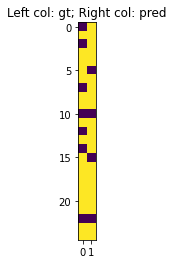

In [43]:
## VISUALIZE model output and parameters on test data

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())
    
    
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))

        
predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

plt.imshow(viz)
plt.title("Left col: gt; Right col: pred")

err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
err_perc



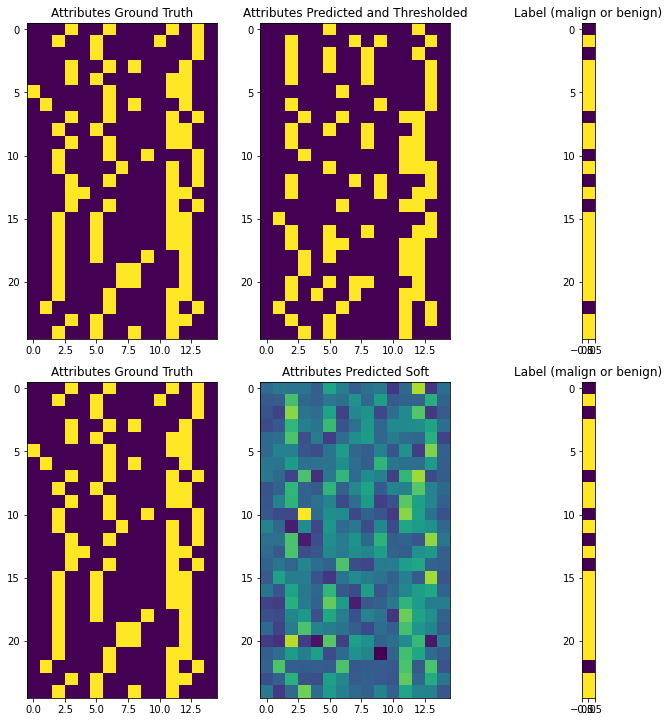

In [45]:
## ALL this should be on TEST set
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(np.expand_dims(viz[:, 0], 1))
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(np.expand_dims(viz[:, 0], 1))
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

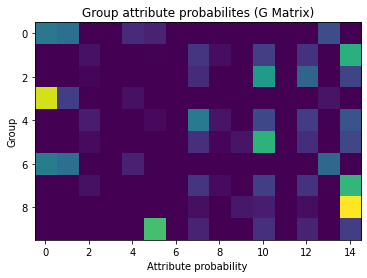

In [46]:
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")